In [1]:
# update the git
! git add  .
! git commit -m "From Mac"
! git push

[master 61297199] From Mac
 2 files changed, 2330 insertions(+), 3118 deletions(-)
 rewrite NeuralNetwork/AAE/.ipynb_checkpoints/0 AE on MSE-checkpoint.ipynb (78%)
 rewrite NeuralNetwork/AAE/0 AE on MSE.ipynb (78%)
Counting objects: 6, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 186.43 KiB | 12.43 MiB/s, done.
Total 6 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   d0d63d56..61297199  master -> master


In [2]:
# import library
import tensorflow as tf
import matplotlib 
matplotlib.use('Agg')
%matplotlib inline
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [3]:
# get the fashion mnist data set
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
x_data_added,x_data_added_label = mnist.validation.images,mnist.validation.labels
x_data = x_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
y_data = y_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
x_data_added = x_data_added.reshape(-1, 28, 28, 1)
x_data = np.vstack((x_data,x_data_added))
train_label = np.vstack((train_label,x_data_added_label))

train_batch = np.zeros((5000,28,28,1))
test_batch = np.zeros((10000,28,28,1))
for x in range(5000):
    train_batch[x,:,:,:] = np.expand_dims(resize(x_data[x,:,:,0],(28,28)),axis=3)

# print out the data shape and the max and min value
print(train_batch.shape)
print(train_batch.max())
print(train_batch.min())
print(train_label.shape)
print(train_label.max())
print(train_label.min())
print(test_batch.shape)
print(test_batch.max())
print(test_batch.min())
print(test_label.shape)
print(test_label.max())
print(test_label.min())

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


(5000, 28, 28, 1)
1.0
0.0
(60000, 10)
1.0
0.0
(10000, 28, 28, 1)
0.0
0.0
(10000, 10)
1.0
0.0


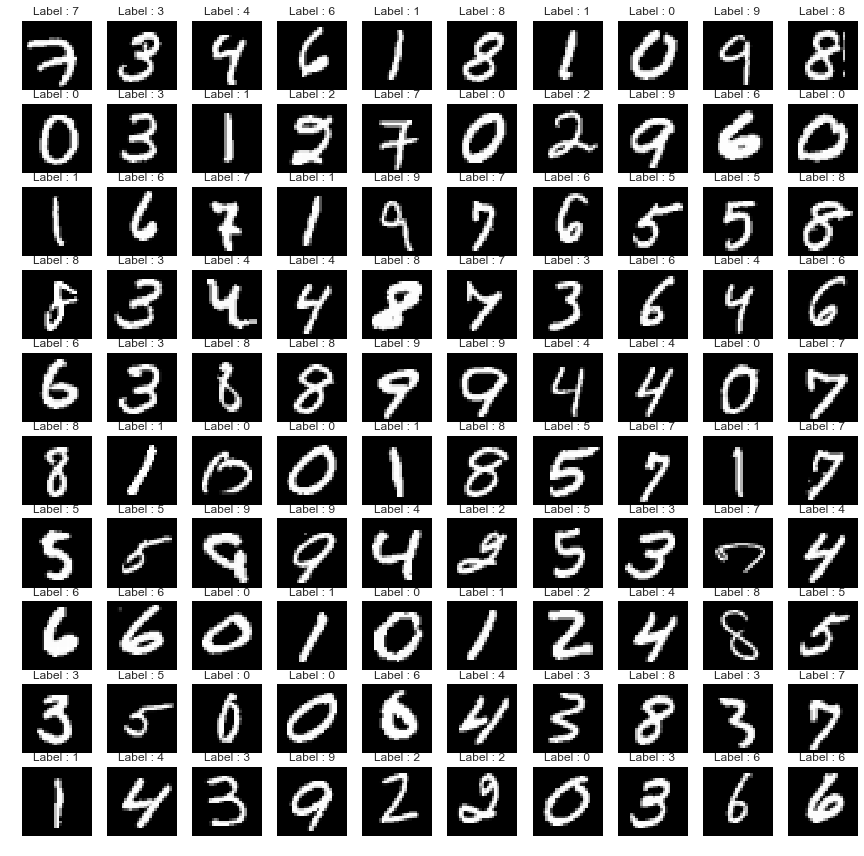

In [4]:
# show small amount of fashion
fig=plt.figure(figsize=(15, 15))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
    plt.title("Label : "+str(np.argmax(train_label[i-1])))
plt.show()

In [19]:
# import all of the layers
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_identiy(x): return x

def tf_relu(x): return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x): return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x): return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x): return x
def d_tf_iden(x): return 1.0

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x): return tf.sqrt(x ** 2 + 1e-20)

def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class FNN():

    def __init__(self,inc,outc,act=tf_elu,d_act=d_tf_elu,special_init=False,which_reg=0.0):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w  = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float32,seed=4))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient=None,which_reg=0):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        # === Reg ===        
        if self.which_reg == 0:
            grad = grad

        if self.which_reg == 0.5:
            grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)

        if self.which_reg == 1:
            grad = grad + lamda * tf.sign(self.w)

        if self.which_reg == 1.5:
            grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w

        if self.which_reg == 2:
            grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)

        if self.which_reg == 2.5:
            grad = grad + lamda * 2.0 * self.w

        if self.which_reg == 3:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)

        if self.which_reg == 4:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        return grad_pass,update_w

class CNN():

    def __init__(self,k,inc,out,stddev=0.005,which_reg=0,act=tf_elu,d_act=d_tf_elu,residual=False):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg
        self.residual = residual

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='VALID'):
        self.input  = input
        if self.residual: 
            self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding='SAME')
            self.layerA = self.act(self.layer) + input
        else:
            self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
            self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        if self.residual: 
            grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding='SAME'
            ) / batch_size
            
            grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding='SAME'
            ) + gradient
        else: 
            grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding=padding
            ) / batch_size
        
            grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding=padding
            )

        # === Reg ===        
        if self.which_reg == 0:
            grad = grad

        if self.which_reg == 0.5:
            grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)

        if self.which_reg == 1:
            grad = grad + lamda * tf.sign(self.w)

        if self.which_reg == 1.5:
            grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w

        if self.which_reg == 2:
            grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)

        if self.which_reg == 2.5:
            grad = grad + lamda * 2.0 * self.w

        if self.which_reg == 3:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)

        if self.which_reg == 4:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w

In [20]:
# hyper class
num_epoch = 101; learning_rate = 0.0008 ; batch_size = 100; print_size = 2
lamda = 0.0
beta1,beta2,adam_e = 0.9,0.999,1e-8

e1 = CNN(3,1,16,which_reg=2.5,residual=False)
e2 = CNN(3,16,16,which_reg=2.5,residual=True)
e3 = FNN(28*28*16,2,which_reg=2.5,act=tf_tanh,d_act=d_tf_tanh)

d1 = FNN(2,28*28*16,which_reg=2.5)
d2 = CNN(3,16,16,which_reg=2.5,residual=True)
d3 = CNN(3,16,1,which_reg=2.5,residual=False,act=tf_sigmoid,d_act=d_tf_sigmoid)

In [21]:
# encoding/decoding (feed forward)
x = tf.placeholder(shape=[batch_size,28,28,1],dtype=tf.float32)

elayer1 = e1.feedforward(x,padding='SAME')
elayer2 = e2.feedforward(elayer1)
elayer2_flat = tf.reshape(elayer2,[batch_size,-1])
elayer3 = e3.feedforward(elayer2_flat)

dlayer1 = d1.feedforward(elayer3)
dlayer_reshape = tf.reshape(dlayer1,[batch_size,28,28,8])
dlayer2 = d2.feedforward(dlayer_reshape)
dlayer3 = d3.feedforward(dlayer2,padding='SAME')

print(elayer1,elayer2)
print(elayer3)
print(dlayer1,dlayer2)
print(dlayer3)

Tensor("Elu_14:0", shape=(100, 28, 28, 8), dtype=float32) Tensor("add_82:0", shape=(100, 28, 28, 8), dtype=float32)
Tensor("MatMul_12:0", shape=(100, 2), dtype=float32)
Tensor("Elu_16:0", shape=(100, 6272), dtype=float32) Tensor("add_83:0", shape=(100, 28, 28, 8), dtype=float32)
Tensor("Sigmoid_6:0", shape=(100, 28, 28, 1), dtype=float32)


In [22]:
# encoding / decoding (back prop)
recon_cost = tf.reduce_mean(tf.square(dlayer3-x))
binary_cost= tf.reduce_mean(x*tf.log(dlayer3 + 10e-5) + (1-x) * tf.log( 1-dlayer3 + 10e-5))
total_cost = recon_cost + binary_cost 

recon_grad = dlayer3- x
binary_grad= (-x/(dlayer3+ 10e-5)) + ((1-x)/(1-dlayer3 + 10e-5))
total_grad = (recon_grad)/batch_size

dgrad3,dgrad3_up = d3.backprop(total_grad,padding='SAME')
dgrad2,dgrad2_up = d2.backprop(dgrad3)
dgrad1_flat = tf.reshape(dgrad2,[batch_size,-1])
dgrad1,dgrad1_up = d1.backprop(dgrad1_flat)

egrad3,egrad3_up = e3.backprop(dgrad1)
egrad3_reshape = tf.reshape(egrad3,[batch_size,28,28,8])
egrad2,egrad2_up = e2.backprop(egrad3_reshape)
egrad1,egrad1_up = e1.backprop(egrad2,padding='SAME')

grad_update =  dgrad3_up + dgrad2_up + dgrad1_up + \
             egrad3_up + egrad2_up + egrad1_up 

print(dgrad3)
print(dgrad2,dgrad1)
print(egrad3)
print(egrad2,egrad1)

Tensor("Conv2DBackpropInput_6:0", shape=(100, 28, 28, 8), dtype=float32)
Tensor("add_97:0", shape=(100, 28, 28, 8), dtype=float32) Tensor("MatMul_15:0", shape=(100, 2), dtype=float32)
Tensor("MatMul_17:0", shape=(100, 6272), dtype=float32)
Tensor("add_114:0", shape=(100, 28, 28, 8), dtype=float32) Tensor("Conv2DBackpropInput_9:0", shape=(100, 28, 28, 1), dtype=float32)


/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


 iter: 0 batch: 4900 cost: -0.23710491

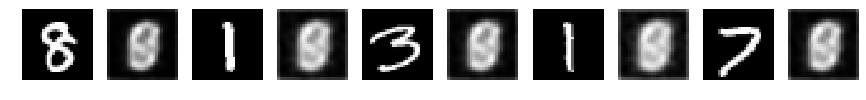

 iter: 2 batch: 4900 cost: -0.19791204

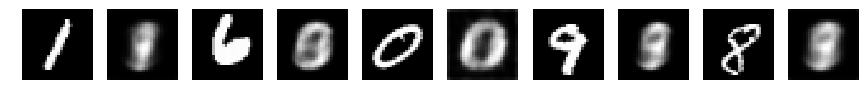

 iter: 4 batch: 4900 cost: -0.19418274

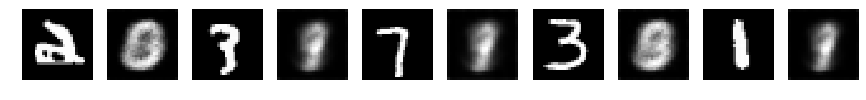

 iter: 6 batch: 4900 cost: -0.20222616

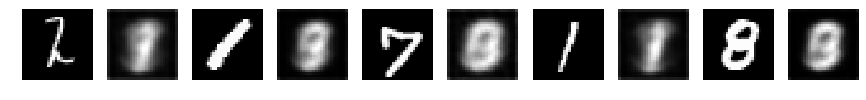

 iter: 8 batch: 4900 cost: -0.19580669

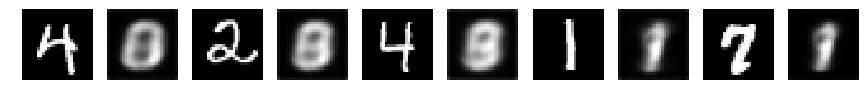

 iter: 10 batch: 4900 cost: -0.19909155

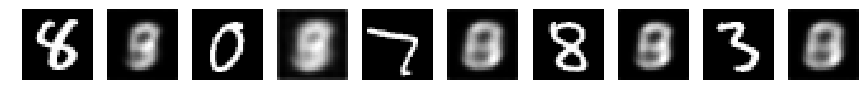

 iter: 12 batch: 4900 cost: -0.20144233

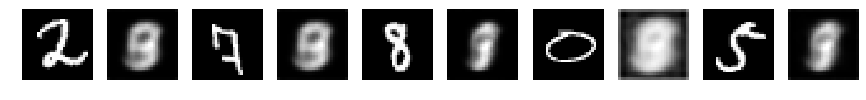

 iter: 14 batch: 4900 cost: -0.19498637

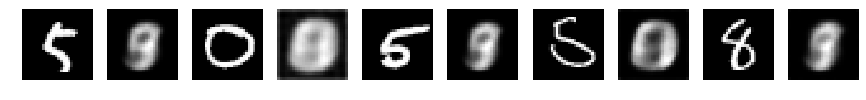

 iter: 16 batch: 4900 cost: -0.27815534

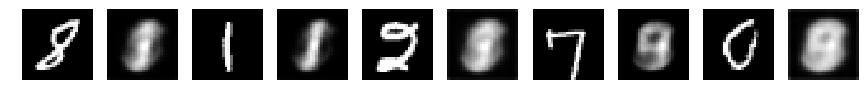

 iter: 18 batch: 4900 cost: -0.45674828

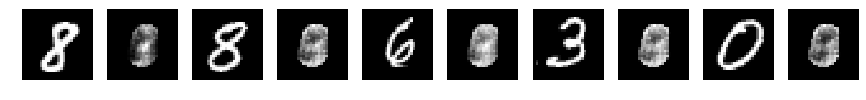

 iter: 20 batch: 4900 cost: -0.23531024

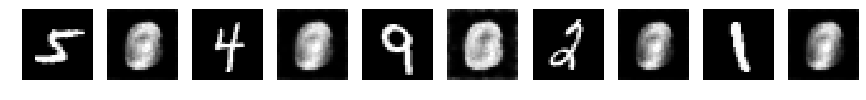

 iter: 22 batch: 4900 cost: -0.20792755

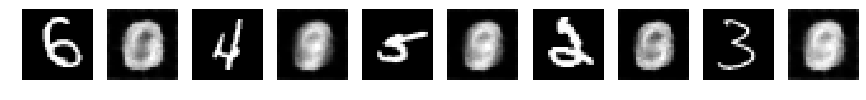

 iter: 24 batch: 4900 cost: -0.20037757

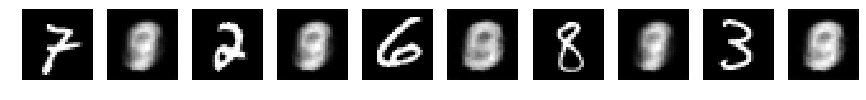

 iter: 26 batch: 4900 cost: -0.19208065

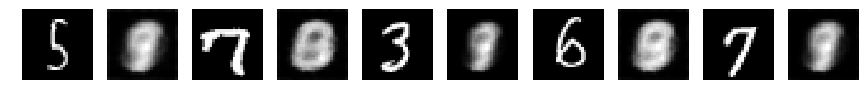

 iter: 28 batch: 4900 cost: -0.19509386

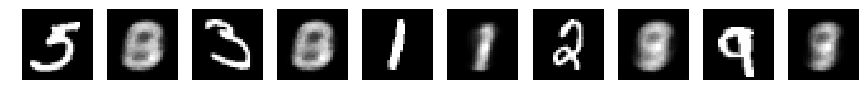

 iter: 30 batch: 4900 cost: -0.19727647

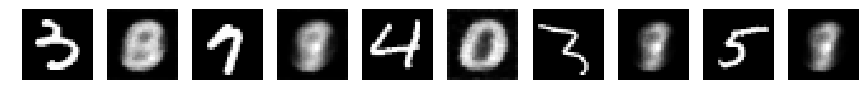

 iter: 32 batch: 4900 cost: -0.19532813

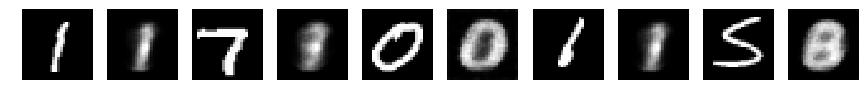

 iter: 34 batch: 4900 cost: -0.20018771

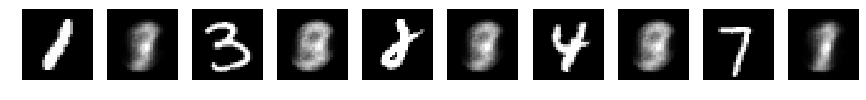

 iter: 36 batch: 4900 cost: -0.20267001

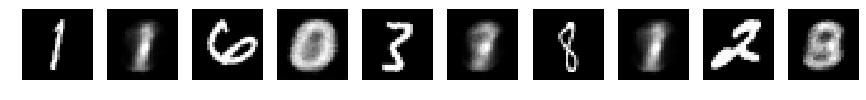

 iter: 38 batch: 4900 cost: -0.21031281

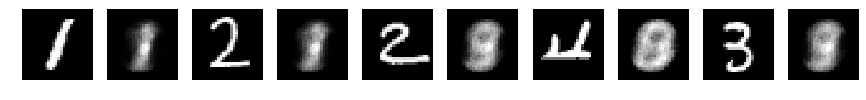

 iter: 40 batch: 4900 cost: -0.20024236

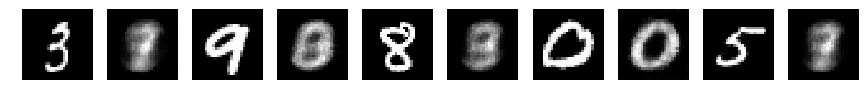

 iter: 42 batch: 4900 cost: -0.19867367

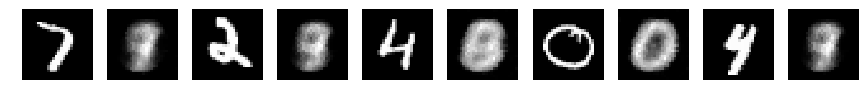

 iter: 44 batch: 4900 cost: -0.20773762

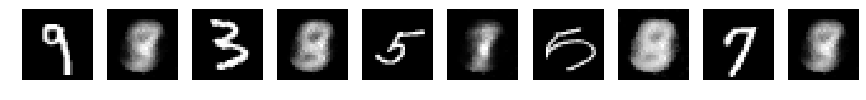

 iter: 46 batch: 4900 cost: -0.20032793

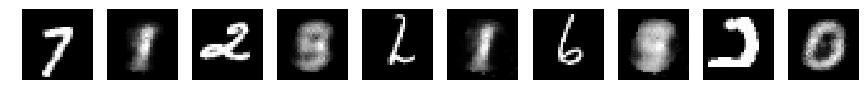

 iter: 48 batch: 4900 cost: -0.21272391

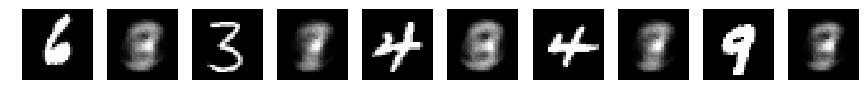

 iter: 50 batch: 4900 cost: -0.22232134

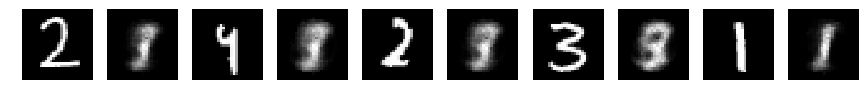

 iter: 52 batch: 4900 cost: -0.22249624

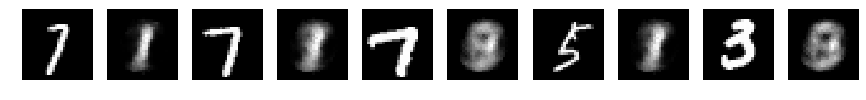

 iter: 54 batch: 4900 cost: -0.21294354

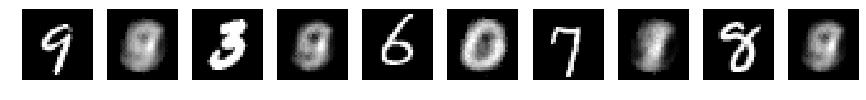

 iter: 56 batch: 4900 cost: -0.22243166

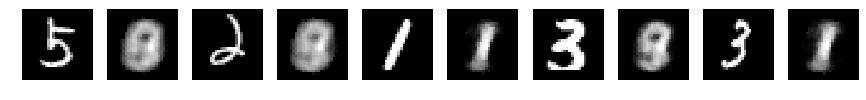

 iter: 58 batch: 4900 cost: -0.20458385

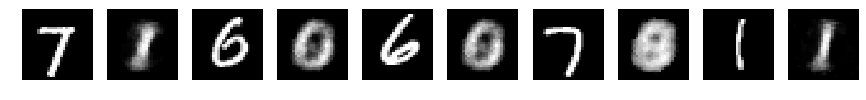

 iter: 60 batch: 4900 cost: -0.21611897

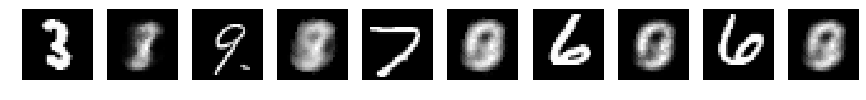

 iter: 62 batch: 4900 cost: -0.23744354

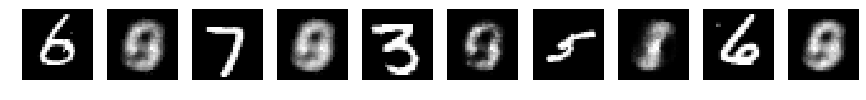

 iter: 64 batch: 4900 cost: -0.20664762

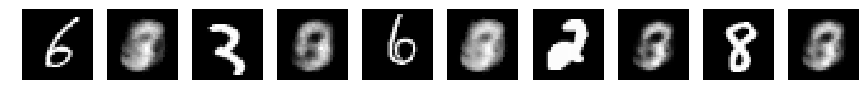

 iter: 66 batch: 4900 cost: -0.24389775

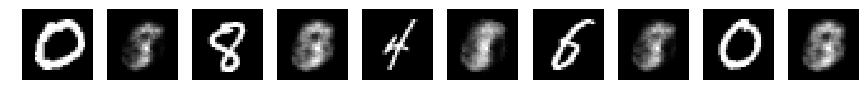

 iter: 68 batch: 4900 cost: -0.24526843

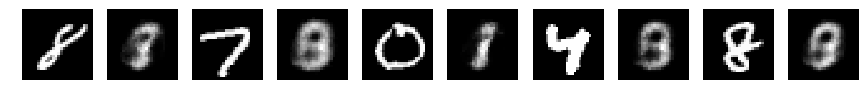

 iter: 70 batch: 4900 cost: -0.23769982

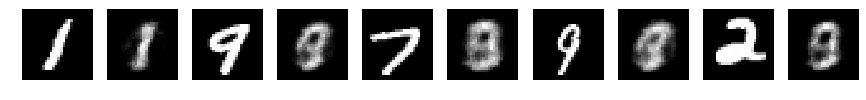

 iter: 72 batch: 4900 cost: -0.24107772

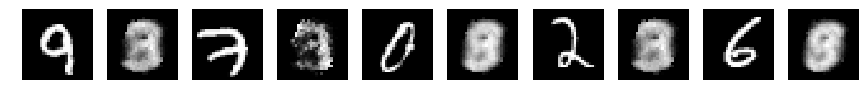

 iter: 74 batch: 4900 cost: -0.23898533

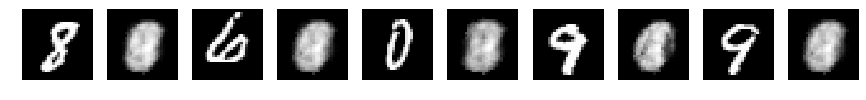

 iter: 76 batch: 4900 cost: -0.23239842

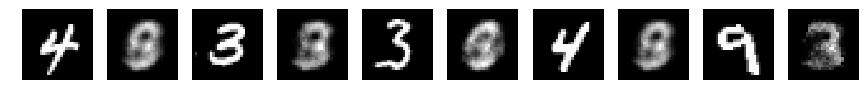

 iter: 78 batch: 4900 cost: -0.25981525

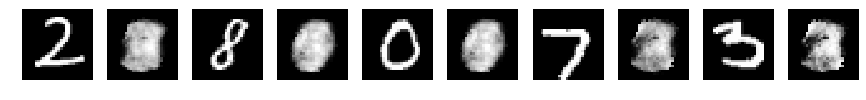

 iter: 80 batch: 4900 cost: -0.24653872

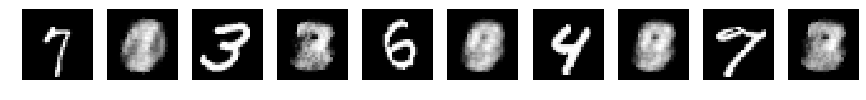

 iter: 82 batch: 4900 cost: -0.24336335

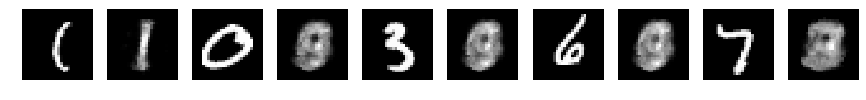

 iter: 84 batch: 4900 cost: -0.41416848

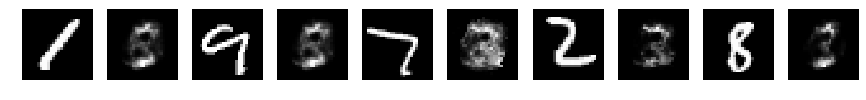

 iter: 86 batch: 4900 cost: -0.28667766

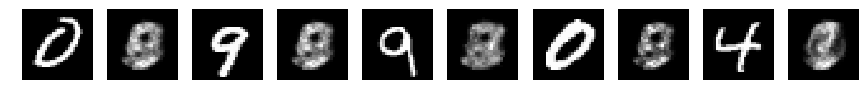

 iter: 88 batch: 4900 cost: -0.26286495

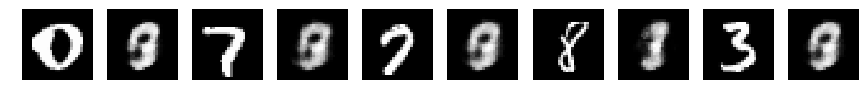

 iter: 90 batch: 4900 cost: -0.23925786

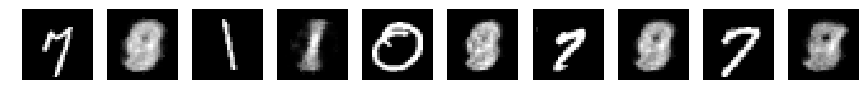

 iter: 92 batch: 4900 cost: -0.32635635

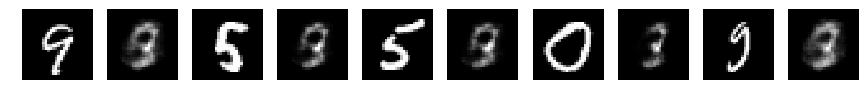

 iter: 94 batch: 4900 cost: -0.25997991

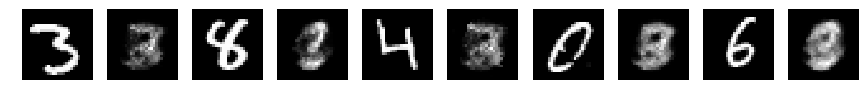

 iter: 96 batch: 4900 cost: -0.25158575

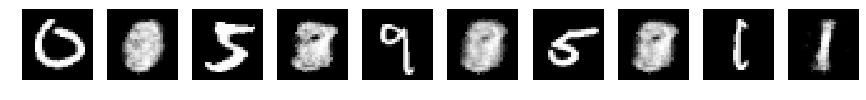

 iter: 98 batch: 4900 cost: -0.35150805

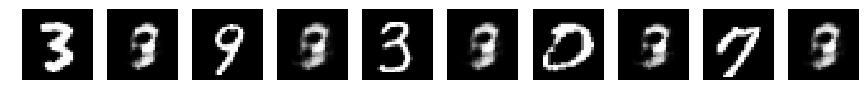

 iter: 100 batch: 4900 cost: -0.25285168

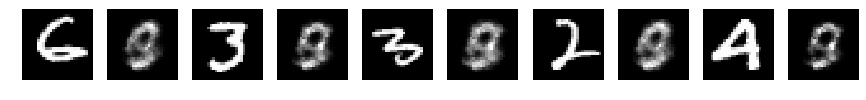

In [23]:
# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_batch_shuffled = train_batch.copy()

for iter in range(num_epoch):
    for current_data_index in range(0,len(train_batch),batch_size):
        current_data = train_batch_shuffled[current_data_index:current_data_index+batch_size].astype(np.float32)
        sess_result = sess.run([total_cost,grad_update],feed_dict={x:current_data})
        sys.stdout.write(
            '\r iter: ' + str(iter) + ' batch: ' + str(current_data_index) + ' cost: ' + str(sess_result[0])
        )
        sys.stdout.flush()
        
    if iter % print_size == 0:
        sess_result = sess.run(dlayer3,feed_dict={x:current_data})
        fig=plt.figure(figsize=(15, 15))
        columns = 10 ; rows = 1
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            if i % 2 ==0 :
                  plt.imshow(np.squeeze(sess_result[i-2]),cmap='gray')
            else:
                plt.imshow(np.squeeze(current_data[i-1]),cmap='gray')
            plt.axis('off')
        plt.show()
        
        train_batch_shuffled = shuffle(train_batch_shuffled)

In [18]:
# convert every data into latent to know the statistics
all_latent_vectors = sess.run(elayer4,feed_dict={x:train_batch[:batch_size]})
print(train_batch.shape)
print(all_latent_vectors.shape)
for current_batch_index in range(batch_size,len(train_batch), batch_size):
    current_train_data = train_batch[current_batch_index:current_batch_index+batch_size]
    sess_results = sess.run(elayer4,feed_dict={x:current_train_data})
    all_latent_vectors = np.vstack((all_latent_vectors,sess_results))
print(all_latent_vectors.shape)

NameError: name 'elayer4' is not defined

In [ ]:
# view the latent vectors
fig = plt.figure(figsize=(10,10))
color_dict = {
    0:'red',
    1:'blue',
    2:'green',
    3:'yellow',
    4:'purple',
    5:'grey',
    6:'black',
    7:'violet',
    8:'silver',
    9:'cyan',
}
color_mapping = [color_dict[x] for x in np.argmax(train_label[:len(train_batch),:],1) ]
plt.title(str(color_dict))
plt.scatter(all_latent_vectors[:,0],all_latent_vectors[:,1],c=color_mapping)
plt.grid()
plt.show()